In [16]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Input
from keras import optimizers, regularizers
from keras import utils 

np.random.seed(697)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv1D,Conv2D, Conv1DTranspose,  Flatten, Dense, Lambda, MaxPooling1D, MaxPooling2D, BatchNormalization, Dropout, Activation, UpSampling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

from tensorflow import keras
from tensorflow.keras import layers,losses

from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers

import pickle
import sys
import os

In [17]:
filename = '../dataSet/BigDataset/dataset_IM_1B.pkl'

with open(filename, 'rb') as f:
    data_tuples = pickle.load(f)
f.close()

class_labels = []
for i in range(len(data_tuples)):
    class_labels.append(data_tuples[i][1])
    
num_class = int(len(data_tuples)/1000)

data = []
for i in range(len(data_tuples)):
    data.append(data_tuples[i][0])
    
data_x=np.array(data)
data_y=np.array(class_labels)


print('Number of images:', len(data_tuples))
print('Number of classes: ', num_class)
print('data_x:', data_x.shape)
print('data_y:', data_y.shape)

Number of images: 6000
Number of classes:  6
data_x: (6000, 28, 28)
data_y: (6000,)


In [18]:
# Random split
# x_train, x_val, y_train, y_val = train_test_split(data_x, data_y,test_size=0.2, shuffle = True, random_state = 8)
# #x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,test_size=0.25, shuffle = True, random_state = 8)

# print('x_train:', x_train.shape)
# print('x_val:', x_val.shape)
# #print('x_test:', x_test.shape)
# print('y_train:', y_train.shape)
# print('y_train:', y_val.shape)
# #print('y_test:', y_test.shape)

x_train: (4800, 28, 28)
x_val: (1200, 28, 28)
y_train: (4800,)
y_train: (1200,)


In [22]:
y_test[800]

4.0

In [23]:
## Manual split
# Train data
N = int(data_x.shape[0] * 0.6)
num_class = 6
num_measure=1000
interval = int(N / num_class)
k = 0
x_train = np.zeros((N,data_x.shape[1],data_x.shape[2]))
y_train = np.zeros(N)
 
for i in range(0, N, interval):
    x_train[i:i + interval] = data_x[k:k + interval]
    y_train[i:i + interval] = data_y[k:k + interval]
    k += num_measure

#Validation data

N = int(data_x.shape[0] * 0.2)
k = interval
interval = int(N / num_class)
 
x_val = np.zeros((N,data_x.shape[1],data_x.shape[2]))
y_val = np.zeros(N)
 
for i in range(0, N, interval):
    x_val[i:i + interval] = data_x[k:k + interval]
    y_val[i:i + interval] = data_y[k:k + interval]
    k += num_measure

#Test data
N = int(data_x.shape[0] * 0.2)
k = num_measure - interval
interval = int(N / num_class)
x_test = np.zeros((N,data_x.shape[1],data_x.shape[2]))
y_test = np.zeros(N)
 
for i in range(0, N, interval):
    x_test[i:i + interval] = data_x[k:k + interval]
    y_test[i:i + interval] = data_y[k:k + interval]
    k += num_measure
 
    
print('x_train:', x_train.shape)
print('x_val:', x_val.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_val:', y_val.shape)
print('y_test:', y_test.shape)

x_train: (3600, 28, 28)
x_val: (1200, 28, 28)
x_test: (1200, 28, 28)
y_train: (3600,)
y_val: (1200,)
y_test: (1200,)


In [24]:
CLIP_MIN = 0
CLIP_MAX = 1

X_train = x_train.reshape(-1, 28, 28, 1)
X_test = x_test.reshape(-1, 28, 28, 1)        
    # cast pixels to floats, normalize to [0, 1] range
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = (X_train/255.0) #- (1.0 - CLIP_MAX)
X_test = (X_test/255.0) #- (1.0 - CLIP_MAX)

    # one-hot-encode the labels
Y_train = utils.to_categorical(y_train, num_class)
Y_test = utils.to_categorical(y_test, num_class)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)


X_train: (3600, 28, 28, 1)
Y_train: (3600, 6)
X_test: (1200, 28, 28, 1)
Y_test (1200, 6)


In [5]:
class_1 = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
class_1.shape

(3600, 784)

In [6]:
#------------------------------------Build the AutoEncoder------------------------------------
latent_dim = 352 
encoding_dim = latent_dim


# Define input layer
input_data = Input(shape=(class_1.shape[1],))
# Define encoding layer
encoded = Dense(encoding_dim, activation='relu')(input_data)

encoder_model = Model(inputs=input_data, outputs=encoded)

# Define decoding layer
#decoded = Dense(class_1.shape[1], activation='sigmoid')(encoded)
decoded = Dense(class_1.shape[1], activation='linear')(encoded)

decoder_model = Model(inputs=input_data, outputs=decoded)

In [7]:
# Create the autoencoder model
autoencoder = Model(input_data, decoded)

#Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
                  
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=5, mode='auto')


hist_auto = autoencoder.fit(class_1, class_1,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                validation_split=0.2,
                #validation_data=(X_val, X_val),
                callbacks=[early_stopping])

Epoch 1/1000
29/29 [==============================] - 1s 14ms/step - loss: 4.4149e-07 - val_loss: 4.0961e-07
Epoch 2/1000
29/29 [==============================] - 0s 8ms/step - loss: 3.9326e-07 - val_loss: 4.0751e-07
Epoch 3/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.9377e-07 - val_loss: 4.0005e-07
Epoch 4/1000
29/29 [==============================] - 0s 8ms/step - loss: 3.9392e-07 - val_loss: 4.0547e-07
Epoch 5/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.9464e-07 - val_loss: 4.0666e-07
Epoch 6/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.9524e-07 - val_loss: 3.9984e-07
Epoch 7/1000
29/29 [==============================] - 0s 8ms/step - loss: 3.9377e-07 - val_loss: 4.0507e-07
Epoch 8/1000
29/29 [==============================] - 0s 8ms/step - loss: 3.9467e-07 - val_loss: 4.0891e-07
Epoch 9/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.9557e-07 - val_loss: 4.1225e-07
Epoch 10/1000
29/29 [======

29/29 [==============================] - 0s 8ms/step - loss: 3.5905e-07 - val_loss: 3.9679e-07
Epoch 77/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.5720e-07 - val_loss: 3.9400e-07
Epoch 78/1000
29/29 [==============================] - 0s 8ms/step - loss: 3.5627e-07 - val_loss: 3.9518e-07
Epoch 79/1000
29/29 [==============================] - 0s 8ms/step - loss: 3.5424e-07 - val_loss: 3.9263e-07
Epoch 80/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.5621e-07 - val_loss: 3.9972e-07
Epoch 81/1000
29/29 [==============================] - 0s 8ms/step - loss: 3.5100e-07 - val_loss: 3.8931e-07
Epoch 82/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.5084e-07 - val_loss: 3.8643e-07
Epoch 83/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.5072e-07 - val_loss: 3.9073e-07
Epoch 84/1000
29/29 [==============================] - 0s 7ms/step - loss: 3.4641e-07 - val_loss: 3.9573e-07
Epoch 85/1000
29/29 [============

Epoch 151/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.3464e-07 - val_loss: 3.3885e-07
Epoch 152/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.3402e-07 - val_loss: 3.3893e-07
Epoch 153/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.3422e-07 - val_loss: 3.3966e-07
Epoch 154/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.3201e-07 - val_loss: 3.4131e-07
Epoch 155/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.3183e-07 - val_loss: 3.3184e-07
Epoch 156/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.2902e-07 - val_loss: 3.3523e-07
Epoch 157/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.2764e-07 - val_loss: 3.3394e-07
Epoch 158/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.2665e-07 - val_loss: 3.3980e-07
Epoch 159/1000
29/29 [==============================] - 0s 7ms/step - loss: 2.2594e-07 - val_loss: 3.3695e-07
Epoch 160/

29/29 [==============================] - 0s 6ms/step - loss: 1.8136e-07 - val_loss: 3.1209e-07
Epoch 226/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.8070e-07 - val_loss: 3.1089e-07
Epoch 227/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.8130e-07 - val_loss: 3.1319e-07
Epoch 228/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.8098e-07 - val_loss: 3.0895e-07
Epoch 229/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.8016e-07 - val_loss: 3.1062e-07
Epoch 230/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.7979e-07 - val_loss: 3.0955e-07
Epoch 231/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.7859e-07 - val_loss: 3.1228e-07
Epoch 232/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.7929e-07 - val_loss: 3.1062e-07
Epoch 233/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.7866e-07 - val_loss: 3.0964e-07
Epoch 234/1000
29/29 [===

29/29 [==============================] - 0s 7ms/step - loss: 1.6093e-07 - val_loss: 3.0199e-07
Epoch 300/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.6055e-07 - val_loss: 3.0381e-07
Epoch 301/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.6034e-07 - val_loss: 3.0040e-07
Epoch 302/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.5938e-07 - val_loss: 3.0204e-07
Epoch 303/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.5885e-07 - val_loss: 2.9962e-07
Epoch 304/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.5781e-07 - val_loss: 3.0303e-07
Epoch 305/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.5870e-07 - val_loss: 3.0225e-07
Epoch 306/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.5930e-07 - val_loss: 2.9829e-07
Epoch 307/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.5861e-07 - val_loss: 2.9652e-07
Epoch 308/1000
29/29 [===

29/29 [==============================] - 0s 7ms/step - loss: 1.4823e-07 - val_loss: 2.9195e-07
Epoch 374/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.4769e-07 - val_loss: 2.9107e-07
Epoch 375/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.4813e-07 - val_loss: 2.9340e-07
Epoch 376/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.4680e-07 - val_loss: 2.8585e-07
Epoch 377/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.4674e-07 - val_loss: 2.8971e-07
Epoch 378/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.4594e-07 - val_loss: 2.9062e-07
Epoch 379/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.4623e-07 - val_loss: 2.8978e-07
Epoch 380/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.4614e-07 - val_loss: 2.8426e-07
Epoch 381/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.4550e-07 - val_loss: 2.9076e-07
Epoch 382/1000
29/29 [===

29/29 [==============================] - 0s 7ms/step - loss: 1.4047e-07 - val_loss: 2.8009e-07
Epoch 448/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.3896e-07 - val_loss: 2.8652e-07
Epoch 449/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3931e-07 - val_loss: 2.8148e-07
Epoch 450/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3929e-07 - val_loss: 2.8291e-07
Epoch 451/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3907e-07 - val_loss: 2.8166e-07
Epoch 452/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3861e-07 - val_loss: 2.8379e-07
Epoch 453/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3862e-07 - val_loss: 2.8466e-07
Epoch 454/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3901e-07 - val_loss: 2.8290e-07
Epoch 455/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3882e-07 - val_loss: 2.8565e-07
Epoch 456/1000
29/29 [===

29/29 [==============================] - 0s 7ms/step - loss: 1.3430e-07 - val_loss: 2.7742e-07
Epoch 522/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.3422e-07 - val_loss: 2.7616e-07
Epoch 523/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3412e-07 - val_loss: 2.8069e-07
Epoch 524/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3439e-07 - val_loss: 2.7609e-07
Epoch 525/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3370e-07 - val_loss: 2.7557e-07
Epoch 526/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3366e-07 - val_loss: 2.7734e-07
Epoch 527/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3348e-07 - val_loss: 2.7388e-07
Epoch 528/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3402e-07 - val_loss: 2.7495e-07
Epoch 529/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.3408e-07 - val_loss: 2.7720e-07
Epoch 530/1000
29/29 [===

29/29 [==============================] - 0s 7ms/step - loss: 1.3100e-07 - val_loss: 2.7121e-07
Epoch 596/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3057e-07 - val_loss: 2.7243e-07
Epoch 597/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3055e-07 - val_loss: 2.7140e-07
Epoch 598/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.3052e-07 - val_loss: 2.7106e-07
Epoch 599/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3129e-07 - val_loss: 2.7238e-07
Epoch 600/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.3083e-07 - val_loss: 2.6707e-07
Epoch 601/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.3033e-07 - val_loss: 2.6881e-07
Epoch 602/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.3029e-07 - val_loss: 2.6743e-07
Epoch 603/1000
29/29 [==============================] - 0s 6ms/step - loss: 1.3066e-07 - val_loss: 2.7063e-07
Epoch 604/1000
29/29 [===

29/29 [==============================] - 0s 7ms/step - loss: 1.2790e-07 - val_loss: 2.6968e-07
Epoch 670/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2765e-07 - val_loss: 2.6537e-07
Epoch 671/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2755e-07 - val_loss: 2.6125e-07
Epoch 672/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2804e-07 - val_loss: 2.6434e-07
Epoch 673/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2776e-07 - val_loss: 2.6052e-07
Epoch 674/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2746e-07 - val_loss: 2.6319e-07
Epoch 675/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2756e-07 - val_loss: 2.6157e-07
Epoch 676/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2780e-07 - val_loss: 2.6614e-07
Epoch 677/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2758e-07 - val_loss: 2.5898e-07
Epoch 678/1000
29/29 [===

29/29 [==============================] - 0s 7ms/step - loss: 1.2558e-07 - val_loss: 2.5859e-07
Epoch 744/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2527e-07 - val_loss: 2.5968e-07
Epoch 745/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.2553e-07 - val_loss: 2.5277e-07
Epoch 746/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2516e-07 - val_loss: 2.6452e-07
Epoch 747/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2508e-07 - val_loss: 2.5972e-07
Epoch 748/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2478e-07 - val_loss: 2.6238e-07
Epoch 749/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2505e-07 - val_loss: 2.5627e-07
Epoch 750/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.2532e-07 - val_loss: 2.5425e-07
Epoch 751/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.2560e-07 - val_loss: 2.5622e-07
Epoch 752/1000
29/29 [===

29/29 [==============================] - 0s 7ms/step - loss: 1.2265e-07 - val_loss: 2.4861e-07
Epoch 818/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.2230e-07 - val_loss: 2.5220e-07
Epoch 819/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2229e-07 - val_loss: 2.4842e-07
Epoch 820/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2282e-07 - val_loss: 2.4992e-07
Epoch 821/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2215e-07 - val_loss: 2.5150e-07
Epoch 822/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.2212e-07 - val_loss: 2.4762e-07
Epoch 823/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.2295e-07 - val_loss: 2.5060e-07
Epoch 824/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.2234e-07 - val_loss: 2.4752e-07
Epoch 825/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.2176e-07 - val_loss: 2.5049e-07
Epoch 826/1000
29/29 [===

29/29 [==============================] - 0s 8ms/step - loss: 1.1927e-07 - val_loss: 2.4725e-07
Epoch 892/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.1913e-07 - val_loss: 2.4432e-07
Epoch 893/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.1967e-07 - val_loss: 2.3988e-07
Epoch 894/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.1948e-07 - val_loss: 2.4732e-07
Epoch 895/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.1918e-07 - val_loss: 2.4292e-07
Epoch 896/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.1957e-07 - val_loss: 2.4112e-07
Epoch 897/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.1972e-07 - val_loss: 2.4455e-07
Epoch 898/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.1968e-07 - val_loss: 2.4720e-07
Epoch 899/1000
29/29 [==============================] - 0s 7ms/step - loss: 1.1891e-07 - val_loss: 2.4731e-07
Epoch 900/1000
29/29 [===

29/29 [==============================] - 0s 8ms/step - loss: 1.1701e-07 - val_loss: 2.3628e-07
Epoch 966/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.1668e-07 - val_loss: 2.3937e-07
Epoch 967/1000
29/29 [==============================] - 0s 10ms/step - loss: 1.1687e-07 - val_loss: 2.3656e-07
Epoch 968/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.1630e-07 - val_loss: 2.3856e-07
Epoch 969/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.1638e-07 - val_loss: 2.3758e-07
Epoch 970/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.1662e-07 - val_loss: 2.3999e-07
Epoch 971/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.1673e-07 - val_loss: 2.4065e-07
Epoch 972/1000
29/29 [==============================] - 0s 8ms/step - loss: 1.1665e-07 - val_loss: 2.3750e-07
Epoch 973/1000
29/29 [==============================] - 0s 9ms/step - loss: 1.1657e-07 - val_loss: 2.3725e-07
Epoch 974/1000
29/29 [=

In [44]:
PATH_DATA = "Toy_data/"
model_file='Toy_data/model.h5'

classification_model = tf.keras.models.load_model(model_file,compile=False)
classification_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [45]:
attack='fgsm'
eps=0.0007
adv_data_fgsm=np.load(os.path.join(PATH_DATA, 'Adv_%s_eps_%0.4f.npy' % (attack,eps)))

attack='bmi'
eps=0.0005
adv_data_bim=np.load(os.path.join(PATH_DATA, 'Adv_%s_eps_%f.npy' % (attack,eps)))

In [46]:
_, acc  = classification_model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print("Accuracy on the test set: %0.2f%%" % (100*acc))


_, acc = classification_model.evaluate(adv_data_fgsm, Y_test, batch_size=100,verbose=0)
print("Accuracy on the adversarial test set (FGSM): %0.2f%%" % (100*acc))


_, acc = classification_model.evaluate(adv_data_bim, Y_test, batch_size=100,verbose=0)
print("Accuracy on the adversarial test set (BIM): %0.2f%%" % (100*acc))

Accuracy on the test set: 99.33%
Accuracy on the adversarial test set (FGSM): 16.58%
Accuracy on the adversarial test set (BIM): 16.08%


In [47]:
X_test_flat=X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print("Flattened original test data: ", X_test_flat.shape)
re_gen_test=autoencoder(X_test_flat)
re_gen_test=np.array(re_gen_test)
print("Flattened regerated test data: ", re_gen_test.shape)


adv_data_fgsm_flat=adv_data_fgsm.reshape((len(adv_data_fgsm), np.prod(adv_data_fgsm.shape[1:])))
print("Flattened adv (FGSM) test data: ", adv_data_fgsm_flat.shape)
re_gen_adv_fgsm_test=autoencoder(adv_data_fgsm_flat)
re_gen_adv_fgsm_test=np.array(re_gen_adv_fgsm_test)
print("Flattened regerated adv (FGSM) test data: ", re_gen_adv_fgsm_test.shape)


adv_data_bim_flat=adv_data_bim.reshape((len(adv_data_bim), np.prod(adv_data_bim.shape[1:])))
print("Flattened adv (BIM) test data: ", adv_data_bim_flat.shape)
re_gen_adv_bim_test=autoencoder(adv_data_bim_flat)
re_gen_adv_bim_test=np.array(re_gen_adv_bim_test)
print("Flattened regerated adv (BIM) test data: ", re_gen_adv_bim_test.shape)



# Reshape back: Deflattening
X_test_reconstructed = re_gen_test.reshape(-1, 28, 28, 1)   
adv_fgsm_reconstructed = re_gen_adv_fgsm_test.reshape(-1, 28, 28, 1)  
adv_bim_reconstructed = re_gen_adv_bim_test.reshape(-1, 28, 28, 1)

print("Deflattened regerated test data: ", X_test_reconstructed.shape)
print("Deflattened regerated adv (FGSM) test data: ", adv_fgsm_reconstructed.shape)
print("Deflattened regerated adv (BIM) test data: ", adv_bim_reconstructed.shape)


Flattened original test data:  (1200, 784)
Flattened regerated test data:  (1200, 784)
Flattened adv (FGSM) test data:  (1200, 784)
Flattened regerated adv (FGSM) test data:  (1200, 784)
Flattened adv (BIM) test data:  (1200, 784)
Flattened regerated adv (BIM) test data:  (1200, 784)
Deflattened regerated test data:  (1200, 28, 28, 1)
Deflattened regerated adv (FGSM) test data:  (1200, 28, 28, 1)
Deflattened regerated adv (BIM) test data:  (1200, 28, 28, 1)


In [48]:
_, acc  = classification_model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print("Accuracy on the original test set: %0.2f%%" % (100*acc))

_, re_acc = classification_model.evaluate(X_test_reconstructed, Y_test, batch_size=128,verbose=0)
print("Accuracy on the reconstructed test set: %0.2f%%" % (100*re_acc))

print("----------------------------------------------------------")

_, acc = classification_model.evaluate(adv_data_fgsm, Y_test, batch_size=100,verbose=0)
print("Accuracy on the adversarial test set (FGSM): %0.2f%%" % (100*acc))

_, re_acc = classification_model.evaluate(adv_fgsm_reconstructed, Y_test, batch_size=128,verbose=0)
print("Accuracy on the reconstructed adv (FGSM) test set: %0.2f%%" % (100*re_acc))

print("----------------------------------------------------------")

_, acc = classification_model.evaluate(adv_data_bim, Y_test, batch_size=100,verbose=0)
print("Accuracy on the adversarial test set (BIM): %0.2f%%" % (100*acc))

_, re_acc = classification_model.evaluate(adv_bim_reconstructed, Y_test, batch_size=128,verbose=0)
print("Accuracy on the reconstructed adv (BIM) test set: %0.2f%%" % (100*re_acc))


Accuracy on the original test set: 99.33%
Accuracy on the reconstructed test set: 82.92%
----------------------------------------------------------
Accuracy on the adversarial test set (FGSM): 16.58%
Accuracy on the reconstructed adv (FGSM) test set: 16.00%
----------------------------------------------------------
Accuracy on the adversarial test set (BIM): 16.08%
Accuracy on the reconstructed adv (BIM) test set: 16.67%


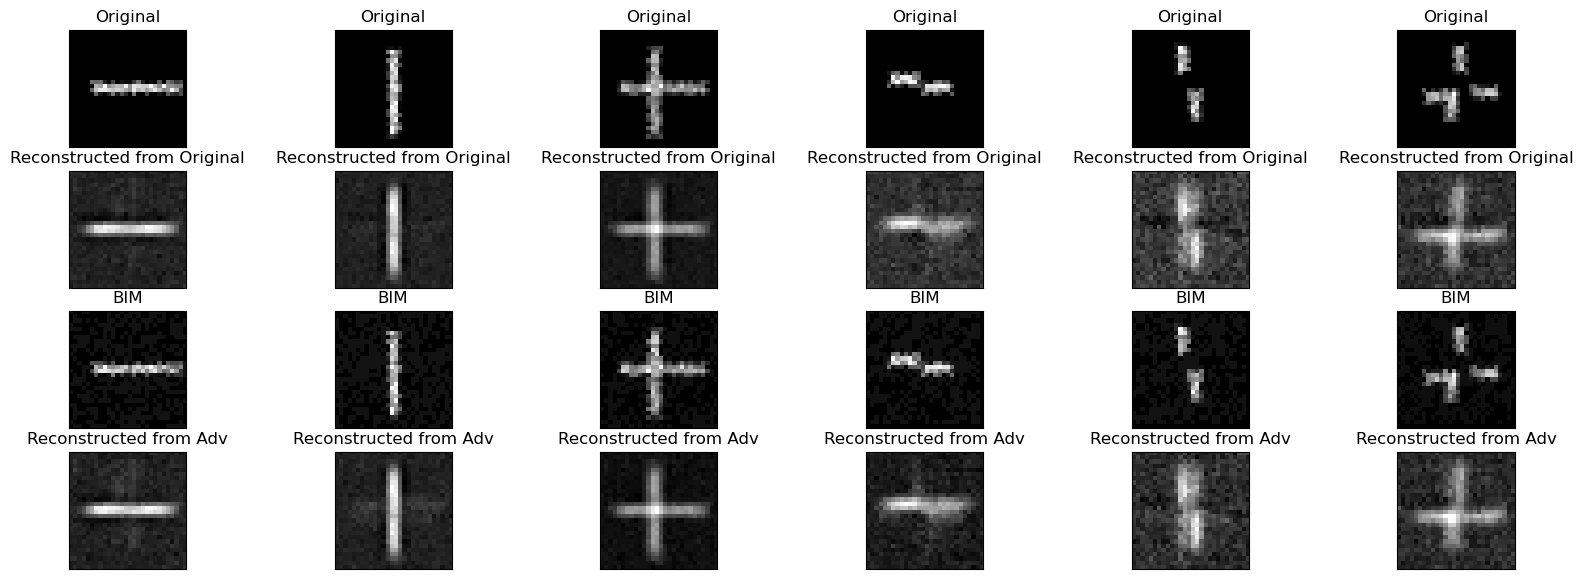

In [15]:
n = 6 
start=2
end=1200
interval=200
plt.figure(figsize=(20,7))
 
k=1

for i in range(start,end,interval):
    # Display original
    ax = plt.subplot(4, n, k)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title(int(y_test[i]))
    ax.set_title('Original')
    
    # Display reconstructed from original
    ax = plt.subplot(4, n, k+n)
    plt.imshow(X_test_reconstructed[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title(int(y_test[i]))
    ax.set_title('Reconstructed from Original')
    
    # Adversarial FGSM
    ax = plt.subplot(4, n, k+2*n)
    plt.imshow(adv_data_bim[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title(adv_data_fgsm_pred_classes[i])
    ax.set_title('BIM')
    
    # Display reconstructed from adversarial
    ax = plt.subplot(4, n, k+3*n)
    plt.imshow(adv_bim_reconstructed[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title(int(y_test[i]))
    ax.set_title('Reconstructed from Adv')  
    k += 1
 
 
#plt.savefig('FGSM.png',dpi=600)
plt.show()

In [16]:
encoder_file='Toy_data/encoder_352_new.h5'
decoder_file='Toy_data/decoder_352_new.h5'

encoder_model = tf.keras.models.load_model(encoder_file)
decoder_model = tf.keras.models.load_model(decoder_file)

In [17]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 352)       3520      
                                                                 
 flatten (Flatten)           (None, 275968)            0         
                                                                 
 dense (Dense)               (None, 352)               97141088  
                                                                 
Total params: 97144608 (370.58 MB)
Trainable params: 97144608 (370.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
decoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 352)]             0         
                                                                 
 dense_1 (Dense)             (None, 784)               276752    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 1)         10        
                                                                 
Total params: 276762 (1.06 MB)
Trainable params: 276762 (1.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Reconstruct the images

X_test=X_test*255.0
X_test_tensor=tf.convert_to_tensor(X_test)


encoded_test=encoder_model.predict(X_test_tensor)
print(encoded_test.shape)
decoded_test=decoder_model.predict(encoded_test)
re_gen_test=np.array(decoded_test)
print("Regenarated test data: ", re_gen_test.shape)


adv_data_fgsm=adv_data_fgsm*255.0
adv_data_fgsm_tensor=tf.convert_to_tensor(adv_data_fgsm)

encoded_adv_fgsm=encoder_model.predict(adv_data_fgsm_tensor)
decoded_adv_fgsm=decoder_model.predict(encoded_adv_fgsm)
re_gen_adv_fgsm=np.array(decoded_adv_fgsm)
print("Regenarated adv (FGSM) data: ", re_gen_adv_fgsm.shape)



adv_data_bim=adv_data_bim*255.0
adv_data_bim_tensor=tf.convert_to_tensor(adv_data_bim)

encoded_adv_bim=encoder_model.predict(adv_data_bim_tensor)
decoded_adv_bim=decoder_model.predict(encoded_adv_bim)
re_gen_adv_bim=np.array(decoded_adv_bim)
print("Regenarated adv (BIM) data: ", re_gen_adv_bim.shape)

38/38 [==============================] - 2s 62ms/step
(1200, 352)
38/38 [==============================] - 0s 2ms/step
Regenarated test data:  (1200, 28, 28, 1)
38/38 [==============================] - 0s 4ms/step
Regenarated adv (FGSM) data:  (1200, 28, 28, 1)
38/38 [==============================] - 0s 3ms/step
Regenarated adv (BIM) data:  (1200, 28, 28, 1)


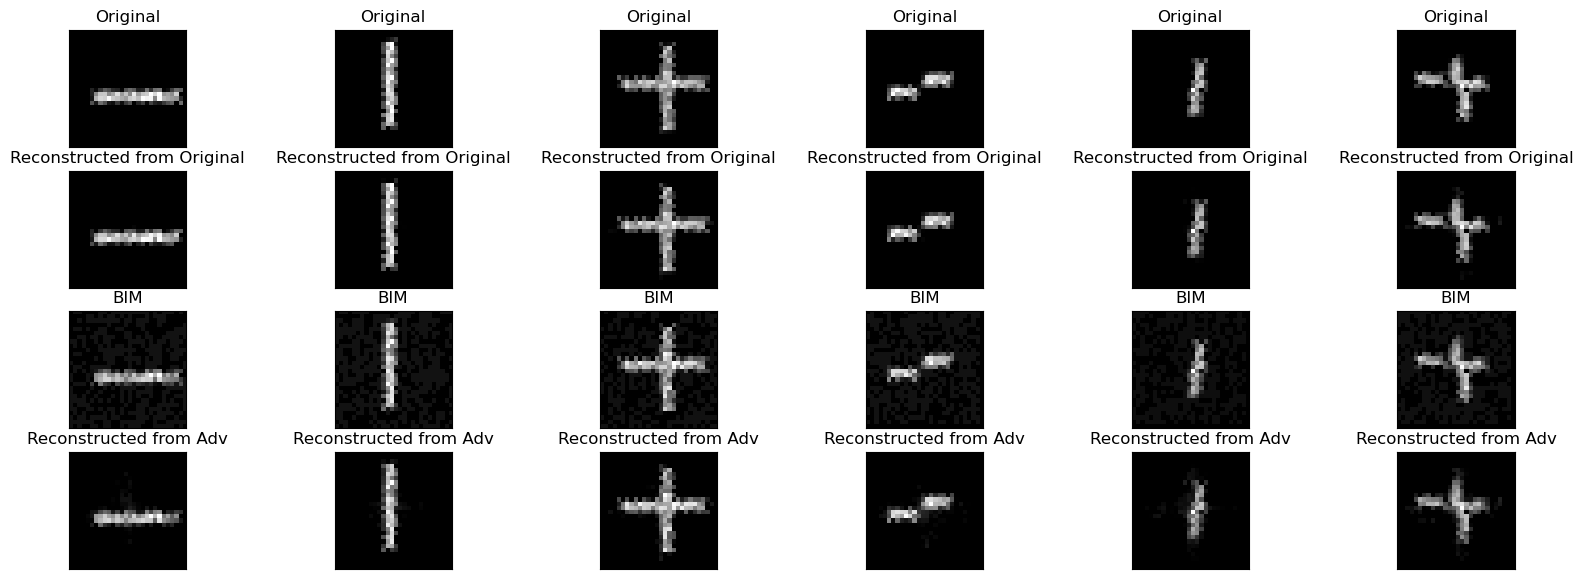

In [20]:
n = 6 
start=0
end=1200
interval=200
plt.figure(figsize=(20,7))
 
k=1

for i in range(start,end,interval):
    # Display original
    ax = plt.subplot(4, n, k)
    plt.imshow(X_test_tensor[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title(int(y_test[i]))
    ax.set_title('Original')
    
    # Display reconstructed from original
    ax = plt.subplot(4, n, k+n)
    plt.imshow(re_gen_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title(int(y_test[i]))
    ax.set_title('Reconstructed from Original')
    
    # Adversarial FGSM
    ax = plt.subplot(4, n, k+2*n)
    plt.imshow(adv_data_bim_tensor[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title(adv_data_fgsm_pred_classes[i])
    ax.set_title('BIM')
    
    # Display reconstructed from adversarial
    ax = plt.subplot(4, n, k+3*n)
    plt.imshow(re_gen_adv_bim[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title(int(y_test[i]))
    ax.set_title('Reconstructed from Adv')  
    k += 1
 
 
#plt.savefig('FGSM.png',dpi=600)
plt.show()

In [21]:
_, acc  = classification_model.evaluate(X_test/255.0, Y_test, batch_size=100, verbose=0)
print("Accuracy on the original test set: %0.2f%%" % (100*acc))

_, re_acc = classification_model.evaluate(re_gen_test/255.0, Y_test, batch_size=128,verbose=0)
print("Accuracy on the reconstructed test set: %0.2f%%" % (100*re_acc))

print("----------------------------------------------------------")

_, acc = classification_model.evaluate(adv_data_fgsm/255.0, Y_test, batch_size=100,verbose=0)

print("Accuracy on the adversarial test set (FGSM): %0.2f%%" % (100*acc))

_, re_acc = classification_model.evaluate(re_gen_adv_fgsm/255.0, Y_test, batch_size=128,verbose=0)

print("Accuracy on the reconstructed adv (FGSM) test set: %0.2f%%" % (100*re_acc))

print("----------------------------------------------------------")

_, acc = classification_model.evaluate(adv_data_bim/255.0, Y_test, batch_size=100,verbose=0)
print("Accuracy on the adversarial test set (BIM): %0.2f%%" % (100*acc))

_, re_acc = classification_model.evaluate(re_gen_adv_bim/255.0, Y_test, batch_size=128,verbose=0)
print("Accuracy on the reconstructed adv (BIM) test set: %0.2f%%" % (100*re_acc))

Accuracy on the original test set: 99.33%
Accuracy on the reconstructed test set: 99.25%
----------------------------------------------------------
Accuracy on the adversarial test set (FGSM): 16.17%
Accuracy on the reconstructed adv (FGSM) test set: 30.33%
----------------------------------------------------------
Accuracy on the adversarial test set (BIM): 27.33%
Accuracy on the reconstructed adv (BIM) test set: 80.83%


In [22]:
# import tensorflow as tf
# import pickle
# import pandas as pd
# import numpy as np
 
# # Load the saved decoder
# saved_encoder = tf.keras.models.load_model('Toy_data/encoder_352_new.h5')
 
# # Load the encoded data
# f = open('../dataSet/BigDataset/dataset_IM_1B.pkl', 'rb')
# data_tuples = pickle.load(f)
# f.close()
# df = pd.DataFrame(data_tuples, columns=['predictor', 'label'])
 
# input_tensor_features  = tf.convert_to_tensor(df['predictor'].tolist())
# input_tensor_features_noise  = input_tensor_features+np.random.normal(0, 0.1, input_tensor_features.shape)

# # Use it to reconstruct data from encoded representations
# reconstructed_data = saved_encoder.predict(input_tensor_features)

In [23]:
# import matplotlib.pyplot as plt
 
# saved_decoder = tf.keras.models.load_model('Toy_data/decoder_352_new.h5')
# imageReconstructed = saved_decoder.predict(reconstructed_data)
 
# plt.figure(figsize=(50, 10), dpi=80)
# for i in range(10):
#     plt.subplot(3,10,i+1)
#     plt.imshow(X_test[100*i//2 + i%2+5], cmap='gray')
#     plt.title(f'Original Image {1000*i//2 + i%2}')
#     plt.axis('off')
# #     plt.subplot(3,10,i+11)
# #     plt.imshow(input_tensor_features_noise[1000*i//2 + i%2+5], cmap='gray')
# #     plt.title('Input image with noise')
# #     plt.axis('off')
#     plt.subplot(3,10,i+21)
#     plt.imshow(imageReconstructed[1000*i//2 + i%2+5], cmap='gray')
#     plt.title('Reconstructed Image')
#     plt.axis('off')
#     plt.suptitle('Random noise from range (0, 0.2) is added to the input image')